In [87]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr

In [3]:
df = pd.read_csv('Data/cleaned.csv')

In [3]:
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,inn00001,2,0,1,2,meal plan 1,0,room_type 1,224,2017,10,2,offline,0,0,0,65.00,0,not_canceled
1,inn00002,2,0,2,3,not selected,0,room_type 1,5,2018,11,6,online,0,0,0,106.68,1,not_canceled
2,inn00003,1,0,2,1,meal plan 1,0,room_type 1,1,2018,2,28,online,0,0,0,60.00,0,canceled
3,inn00004,2,0,0,2,meal plan 1,0,room_type 1,211,2018,5,20,online,0,0,0,100.00,0,canceled
4,inn00005,2,0,1,1,not selected,0,room_type 1,48,2018,4,11,online,0,0,0,94.50,0,canceled


In [34]:
df.columns

Index(['Booking_ID', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status'],
      dtype='object')

In [4]:
# encode booking_status
df['booking_status'] = df['booking_status'].apply(lambda x: 1 if x=='canceled' else 0)

In [145]:
# create booking_date
temp = df.rename(columns={
    'arrival_year': 'year',
    'arrival_month': 'month',
    'arrival_date': 'day'
})

df['booking_date'] = pd.to_datetime(temp[['year', 'month', 'day']], errors='coerce')
df['booking_date'] = df['booking_date'] - pd.Series(
    [pd.Timedelta(i, 'd') for i in df.lead_time],
    index=df.index
)

### Train-Test Split

There are two possible ways of train-test split:
1. Randomly split with 80/20 rule
2. Split base on booking date

In [14]:
# split based on booking_date
train = df[df['booking_date']<'2018-07-01'].reset_index(drop=True)
test = df[df['booking_date']>='2018-07-01'].reset_index(drop=True)

In [16]:
print(f'Size of training set: {len(train)}')
print(f'Size of test set: {len(test)}')

Size of training set: 28062
Size of test set: 8176


### Feature Engineering on Categorical Variables

In [1]:
cat_cols = ['type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 'repeated_guest', 'market_segment_type']

There are several ways for encoding categorical varaibles:
1. LabelEncoder: Assigns a unique integer to each category, suitable for ordinal data where the categories have a natural order
2. OrdinalEncoder: Preserves the ordinal relationship between categories, useful when the categorical variables have an inherent order
3. OneHotEncoder: Creates binary columns for each category, indicating the presence or absence of each category, suitable for nominal data with no ordinal relationship
4. TargetEncoder: Replaces categories with the mean of the target variable for each category, useful for high-cardinality categorical variables

For the above variables, they have small cardinalities and are norminal data, so OneHotEncoding is the most suitable method

In [25]:
# fit on training data
enc = OneHotEncoder(handle_unknown='error')
enc.fit(train[cat_cols])
train[enc.get_feature_names_out()] = enc.transform(train[cat_cols]).toarray()

train.drop(columns=cat_cols, inplace=True)

In [26]:
# transform test data
test[enc.get_feature_names_out()] = enc.transform(test[cat_cols]).toarray()

test.drop(columns=cat_cols, inplace=True)

In [82]:
encoded_cat_cols = enc.get_feature_names_out()

For now, all categories are kept to ensure interpretability. To avoid multicollinearity issues in linear models, an extra step needs to be done to remove one of the categories.

### Feature Engineering on Numerical Variables - Discretization

In [28]:
spec_num_cols = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'no_of_special_requests']

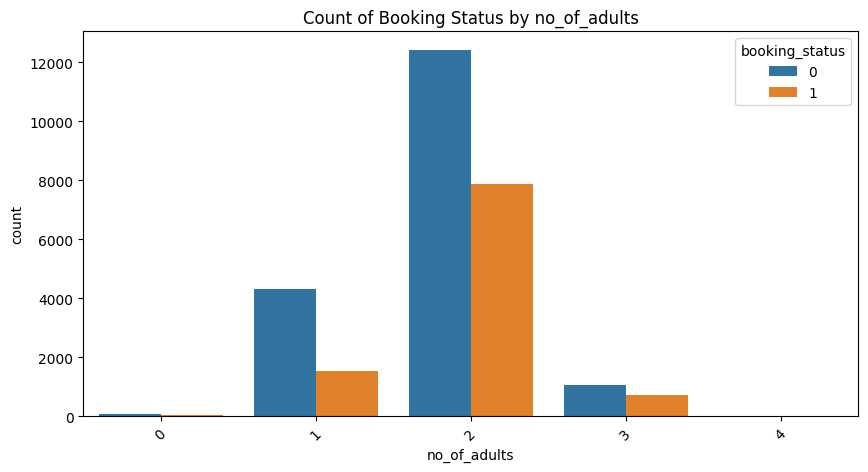

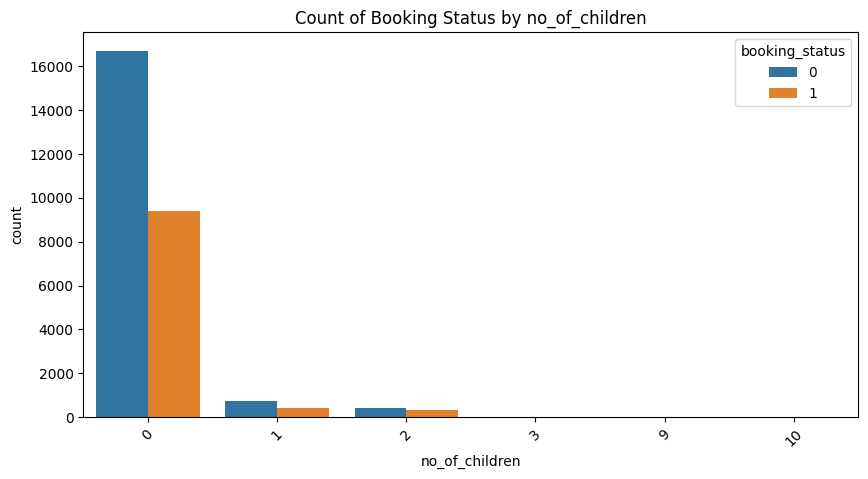

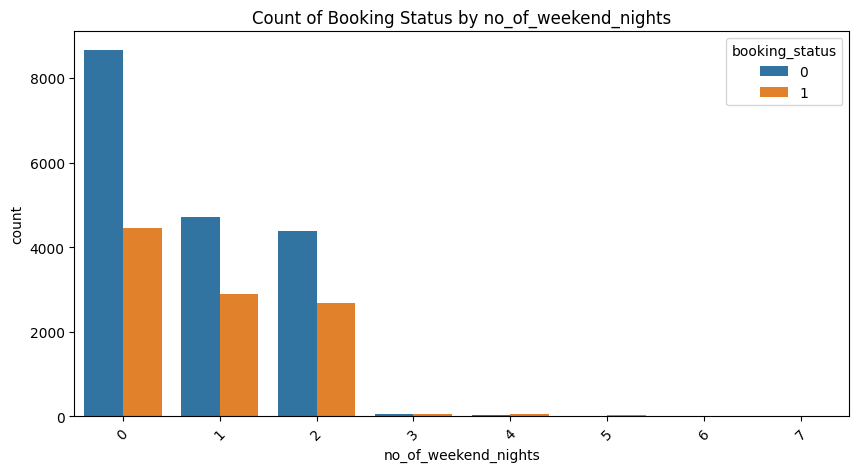

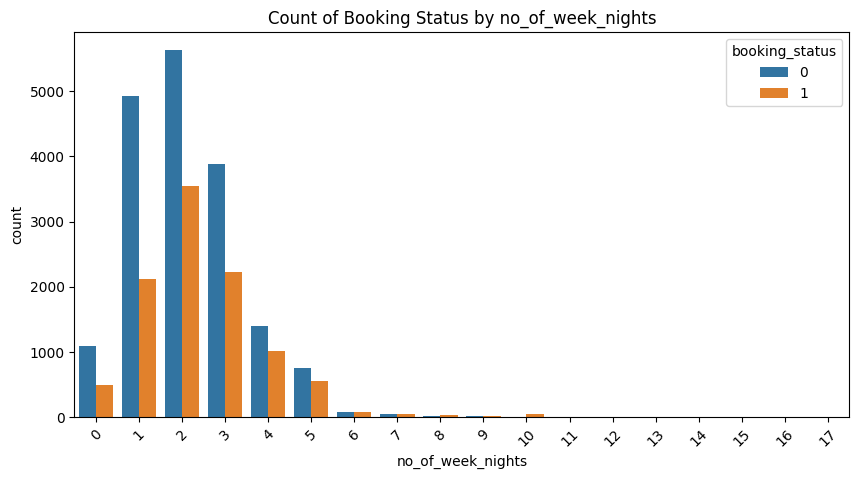

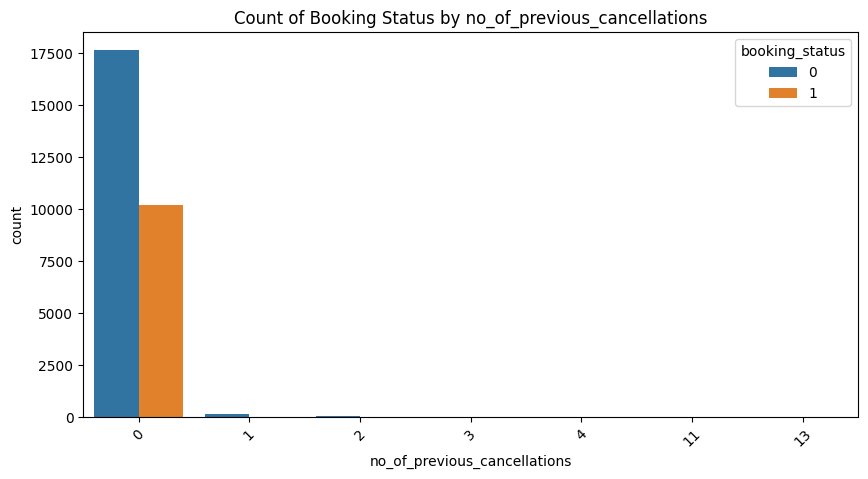

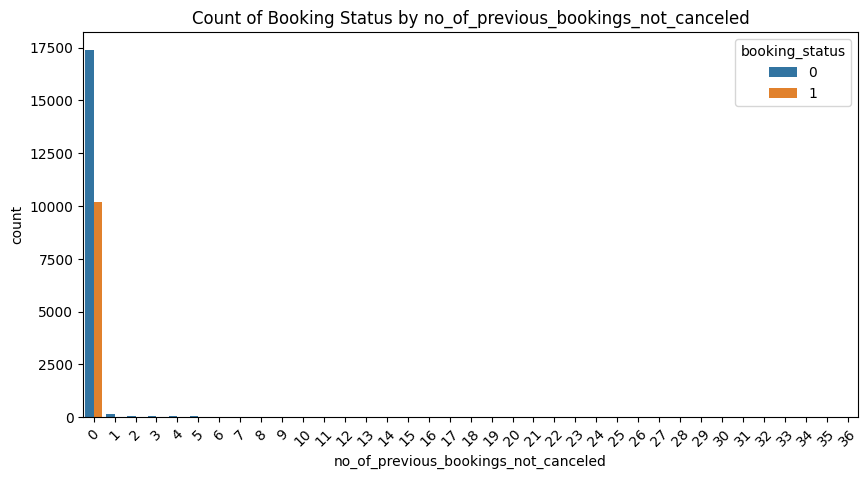

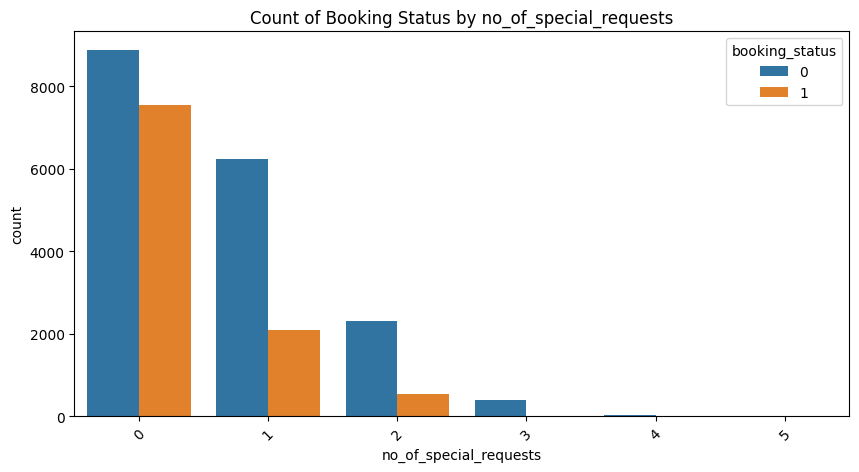

In [30]:
for col in spec_num_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, hue='booking_status', data=train)
    plt.title(f'Count of Booking Status by {col}')
    plt.xticks(rotation=45)
    plt.show()

While these variables take numerical values, the number of unique values is small, so we could transform them into categorical bins.

In [59]:
# no_of_adults: create a >3 category
train['no_of_adults_cat'] = train['no_of_adults'].apply(lambda x: str(x) if x<=3 else 'greater than 3')

# no_of_children: create a >2 category
train['no_of_children_cat'] = train['no_of_children'].apply(lambda x: str(x) if x<=2 else 'greater than 2')

# no_of_weekend_nights: create a >2 category -> stay for more than one week
train['no_of_weekend_nights_cat'] = train['no_of_weekend_nights'].apply(lambda x: str(x) if x<=2 else 'greater than 2')

# no_of_week_nights: create a >7 category -> stay for more than one week
train['no_of_week_nights_cat'] = train['no_of_week_nights'].apply(lambda x: str(x) if x<=7 else 'greater than 7')

# no_of_previous_cancellations: convert to binary
train['no_of_previous_cancellations_cat'] = train['no_of_previous_cancellations'].apply(lambda x: x if x==0 else 1)

# no_of_previous_bookings_not_canceled: convert to binary
train['no_of_previous_bookings_not_canceled_cat'] = train['no_of_previous_bookings_not_canceled'].apply(lambda x: x if x==0 else 1)

# no_of_special_requests: create a >2 category
train['no_of_special_requests_cat'] = train['no_of_special_requests'].apply(lambda x: str(x) if x<=2 else 'greater than 2')

In [50]:
num_cols = ['lead_time', 'avg_price_per_room']

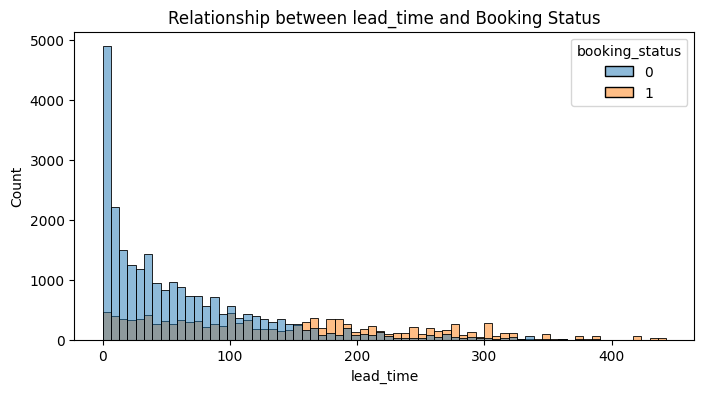

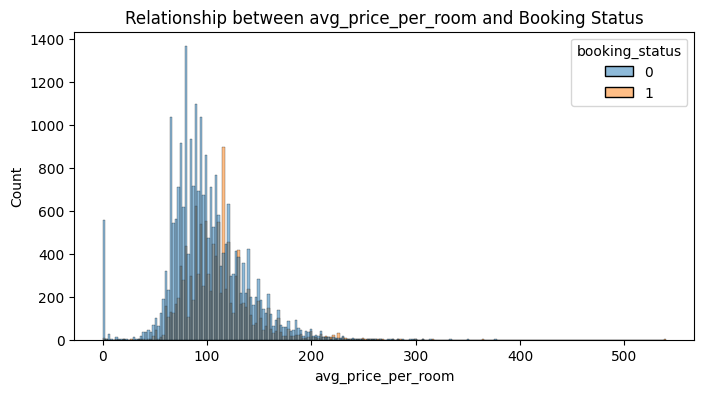

In [51]:
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(x=col, hue='booking_status', data=df)
    plt.title(f'Relationship between {col} and Booking Status')
    plt.show()

We could apply binning to these 2 numerical variables.

In [61]:
def binning(x):
    if x<=50:
        return 'cat 1: 0 to 50'
    elif x<=100:
        return 'cat 2: 50 to 100'
    elif x<=150:
        return 'cat 3: 100 to 150'
    elif x<=200:
        return 'cat 4: 150 to 200'
    elif x<=300:
        return 'cat 5: 200 to 300'
    else:
        return 'cat 6: greater than 300'

In [62]:
# lead_time
train['lead_time_cat'] = train['lead_time'].apply(binning)

# avg_price_per_room
train['avg_price_per_room_cat'] = train['avg_price_per_room'].apply(binning)

In [57]:
spec_cat_cols = ['no_of_adults_cat', 'no_of_children_cat', 'no_of_weekend_nights_cat', 'no_of_week_nights_cat', 'no_of_previous_cancellations_cat', 'no_of_previous_bookings_not_canceled_cat', 'no_of_special_requests_cat', 'lead_time_cat', 'avg_price_per_room_cat']

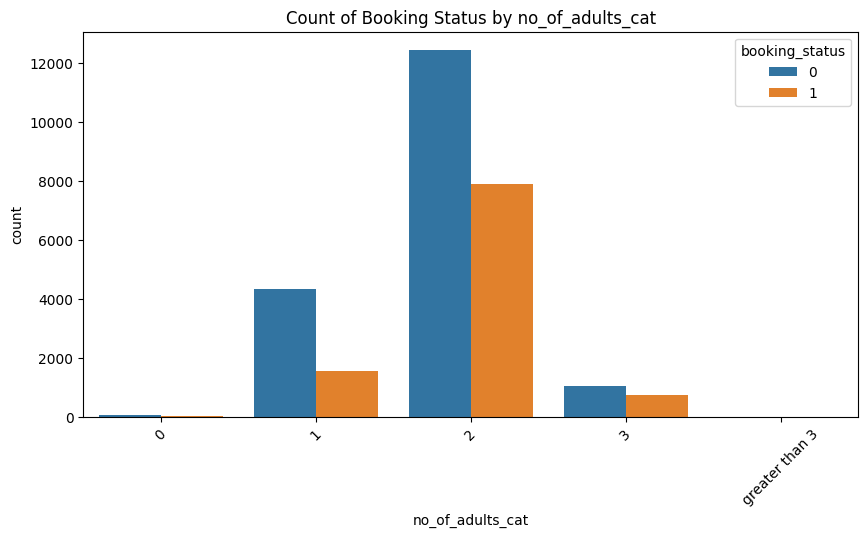

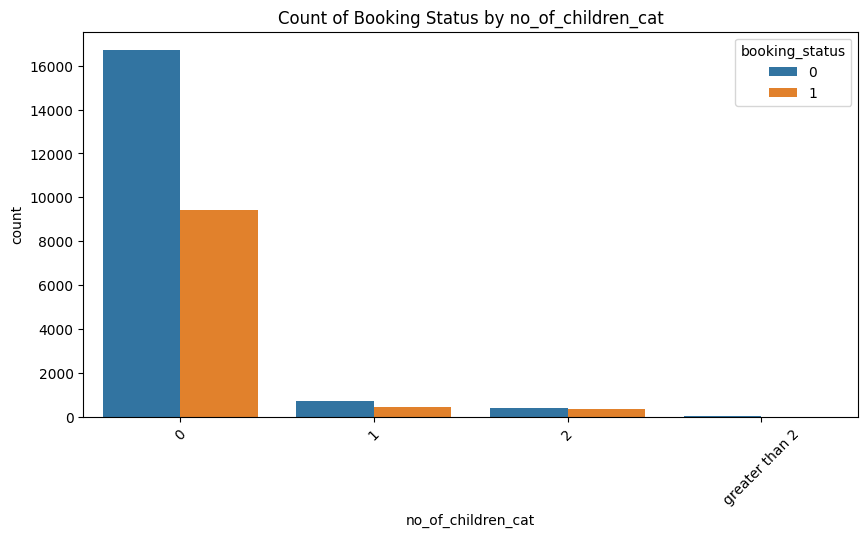

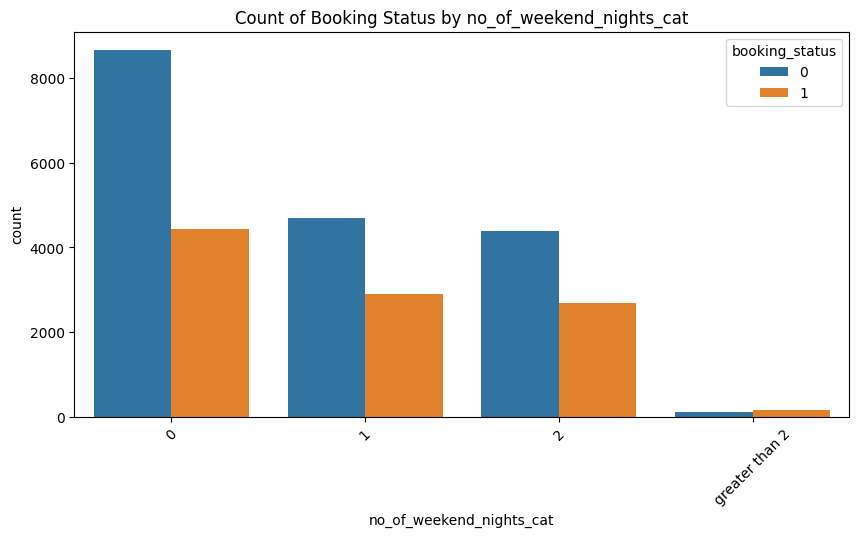

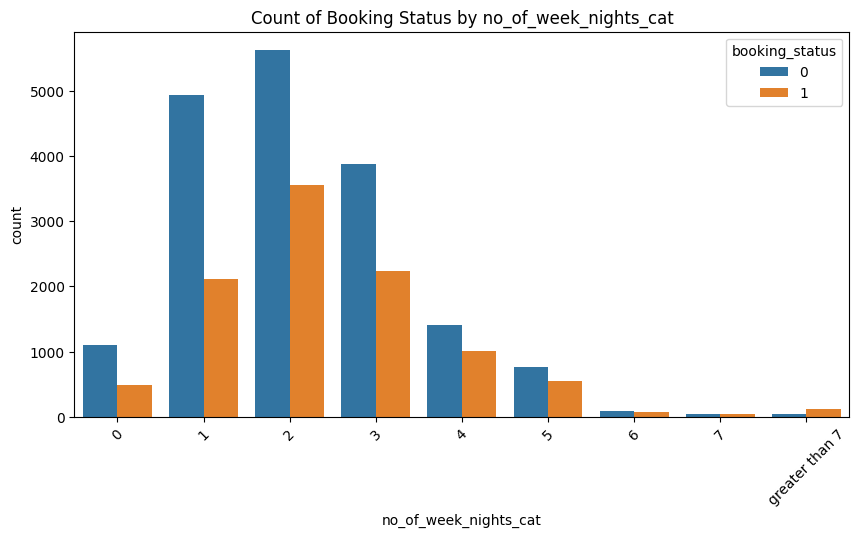

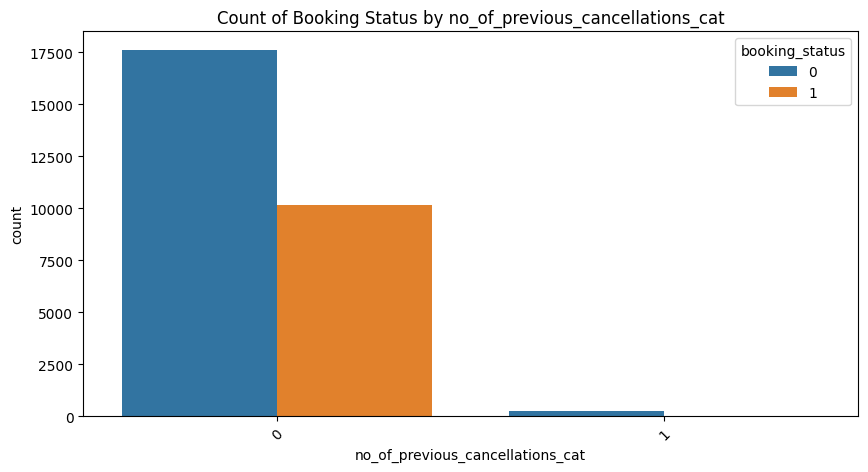

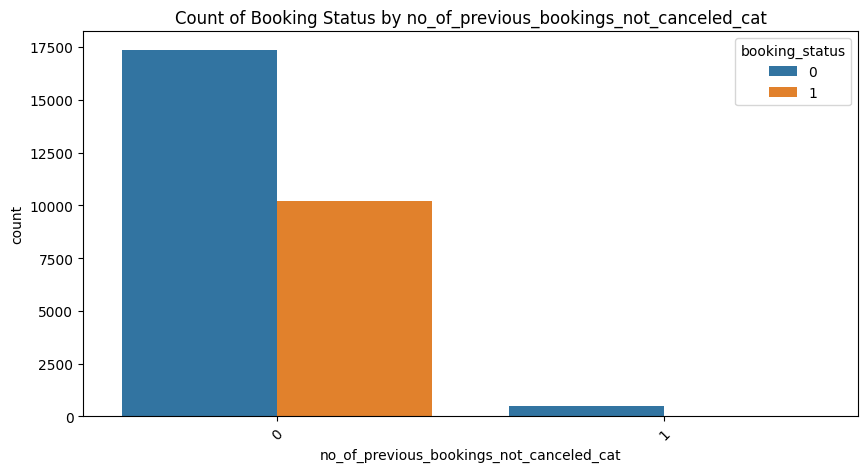

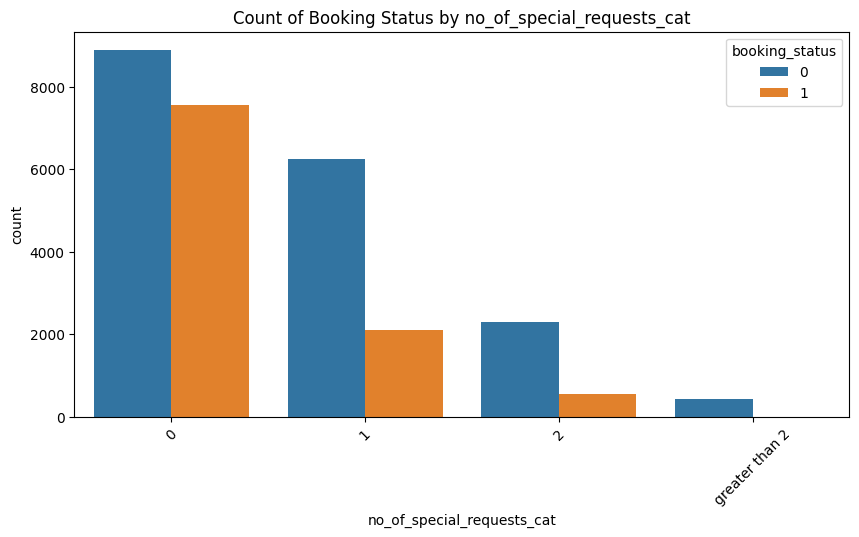

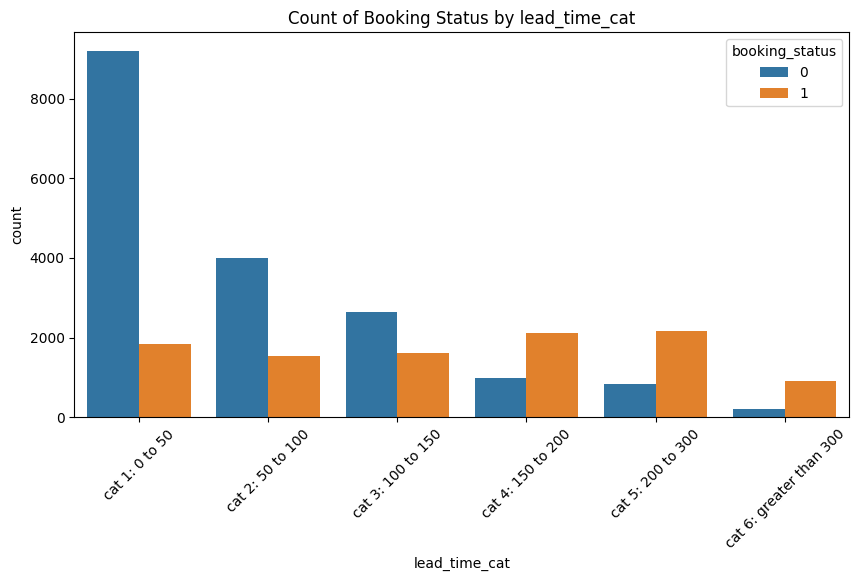

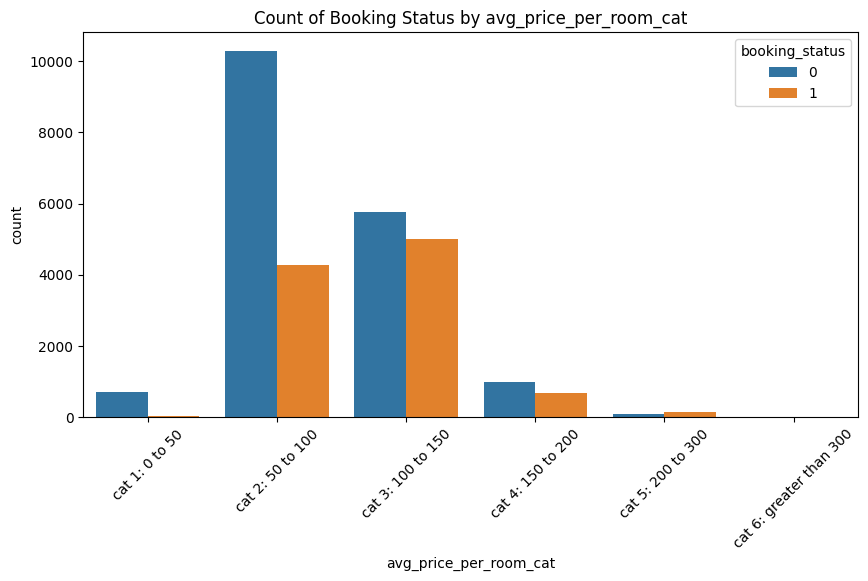

In [63]:
for col in spec_cat_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, hue='booking_status', data=train, order=sorted(train[col].unique()))
    plt.title(f'Count of Booking Status by {col}')
    plt.xticks(rotation=45)
    plt.show()

In [64]:
# no_of_adults: create a >3 category
test['no_of_adults_cat'] = test['no_of_adults'].apply(lambda x: str(x) if x<=3 else 'greater than 3')

# no_of_children: create a >2 category
test['no_of_children_cat'] = test['no_of_children'].apply(lambda x: str(x) if x<=2 else 'greater than 2')

# no_of_weekend_nights: create a >2 category -> stay for more than one week
test['no_of_weekend_nights_cat'] = test['no_of_weekend_nights'].apply(lambda x: str(x) if x<=2 else 'greater than 2')

# no_of_week_nights: create a >7 category -> stay for more than one week
test['no_of_week_nights_cat'] = test['no_of_week_nights'].apply(lambda x: str(x) if x<=7 else 'greater than 7')

# no_of_previous_cancellations: convert to binary
test['no_of_previous_cancellations_cat'] = test['no_of_previous_cancellations'].apply(lambda x: x if x==0 else 1)

# no_of_previous_bookings_not_canceled: convert to binary
test['no_of_previous_bookings_not_canceled_cat'] = test['no_of_previous_bookings_not_canceled'].apply(lambda x: x if x==0 else 1)

# no_of_special_requests: create a >2 category
test['no_of_special_requests_cat'] = test['no_of_special_requests'].apply(lambda x: str(x) if x<=2 else 'greater than 2')

In [65]:
# lead_time
test['lead_time_cat'] = test['lead_time'].apply(binning)

# avg_price_per_room
test['avg_price_per_room_cat'] = test['avg_price_per_room'].apply(binning)

Again, these categorical variables needs to be encoded, and OneHotEncoding will be adopted.

In [66]:
# fit on training data
enc_spec = OneHotEncoder(handle_unknown='error')
enc_spec.fit(train[spec_cat_cols])
train[enc_spec.get_feature_names_out()] = enc_spec.transform(train[spec_cat_cols]).toarray()

train.drop(columns=spec_cat_cols, inplace=True)

In [67]:
# transform test data
test[enc_spec.get_feature_names_out()] = enc_spec.transform(test[spec_cat_cols]).toarray()

test.drop(columns=spec_cat_cols, inplace=True)

In [77]:
encoded_num_cols = enc_spec.get_feature_names_out()

### Feature Engineering on Numerical Variables - Scaling

For machine learning algorithm that requires gradient descent or distance measurement, feature scaling is necessary. There are several ways of scaling:
1. Min-Max Scaling: Scales the data to a fixed range, usually between 0 and 1, useful when the distribution of data is uniform or when the algorithm requires input features to be on a similar scale
2. Standardization: Scales the data to have a mean of 0 and a standard deviation of 1, preserves the shape of the original distribution and is less affected by outliers
3. Robust Scaling: Scales the data based on the interquartile range (IQR) to mitigate the effect of outliers

As observations with extreme values exist in our data and the distribution of data is not of a specific distribution, we will adopt Standardization.

In [75]:
# fit on training data
scaler = StandardScaler()
scaler.fit(train[spec_num_cols+num_cols])
train[[x+'_scaled' for x in spec_num_cols+num_cols]] = scaler.transform(train[spec_num_cols+num_cols])

In [76]:
# transform test data
test[[x+'_scaled' for x in spec_num_cols+num_cols]] = scaler.transform(test[spec_num_cols+num_cols])

In [92]:
scaled_num_cols = [x+'_scaled' for x in spec_num_cols+num_cols]

### Feature Engineering on Dates

In [142]:
def process_arrival_date(df):
    temp = df.rename(columns={
        'arrival_year': 'year',
        'arrival_month': 'month',
        'arrival_date': 'day'
    })

    df['date'] = pd.to_datetime(temp[['year', 'month', 'day']], errors='coerce')
    df['arrival_week'] = df['date'].dt.isocalendar().week.astype(float)
    df['arrival_dayofweek'] = df['date'].dt.dayofweek
    df['arrival_quarter'] = df['date'].dt.quarter
    df['arrival_dayofyear'] = df['date'].dt.dayofyear
    df['arrival_isweekend'] = df['arrival_dayofweek'].apply(lambda x:1 if x>=5 else 0)
    
    df.drop(columns='date', inplace=True)

In [150]:
def process_booking_date(df):
    temp = df.rename(columns={
        'arrival_year': 'year',
        'arrival_month': 'month',
        'arrival_date': 'day'
    })

    df['booking_date'] = pd.to_datetime(temp[['year', 'month', 'day']], errors='coerce')
    df['booking_date'] = df['booking_date'] - pd.Series(
        [pd.Timedelta(i, 'd') for i in df.lead_time],
        index=df.index
    )
    
    df['booking_year'] = df['booking_date'].dt.year
    df['booking_month'] = df['booking_date'].dt.month
    df['booking_week'] = df['booking_date'].dt.isocalendar().week.astype(float)
    df['booking_dayofweek'] = df['booking_date'].dt.dayofweek
    df['booking_quarter'] = df['booking_date'].dt.quarter
    df['booking_dayofyear'] = df['booking_date'].dt.dayofyear
    df['booking_date'] = df['booking_date'].dt.day
    df['booking_isweekend'] = df['arrival_dayofweek'].apply(lambda x:1 if x>=5 else 0)

In [151]:
# process training dates
process_arrival_date(train)
process_booking_date(train)

In [152]:
# process test dates
process_arrival_date(test)
process_booking_date(test)

Barplots showing the total number of booking, lines showing the canceled booking

In [85]:
def plot_dots_ordinal(feature, ax):
    dots = df.groupby(feature)['booking_status'].sum().reset_index()
    dots.sort_values(feature, inplace=True)
    train_containers = ax.containers[0]
    
    containers = [train_containers]
    
    for container in containers:
        x_s = [bar.get_x() + bar.get_width()/2 for bar in container]
        y_s = dots.booking_status
        x_s = x_s[:y_s.shape[0]]
        ax.plot(x_s, y_s, marker='.', alpha=0.8, markersize=10)

In [95]:
booking_columns = ['booking_year', 'booking_quarter', 'booking_month', 'booking_dayofweek', 
           'booking_date', 'booking_week', 'booking_dayofyear']
n_cols = 3
n_rows = math.ceil(len(booking_columns)/n_cols)

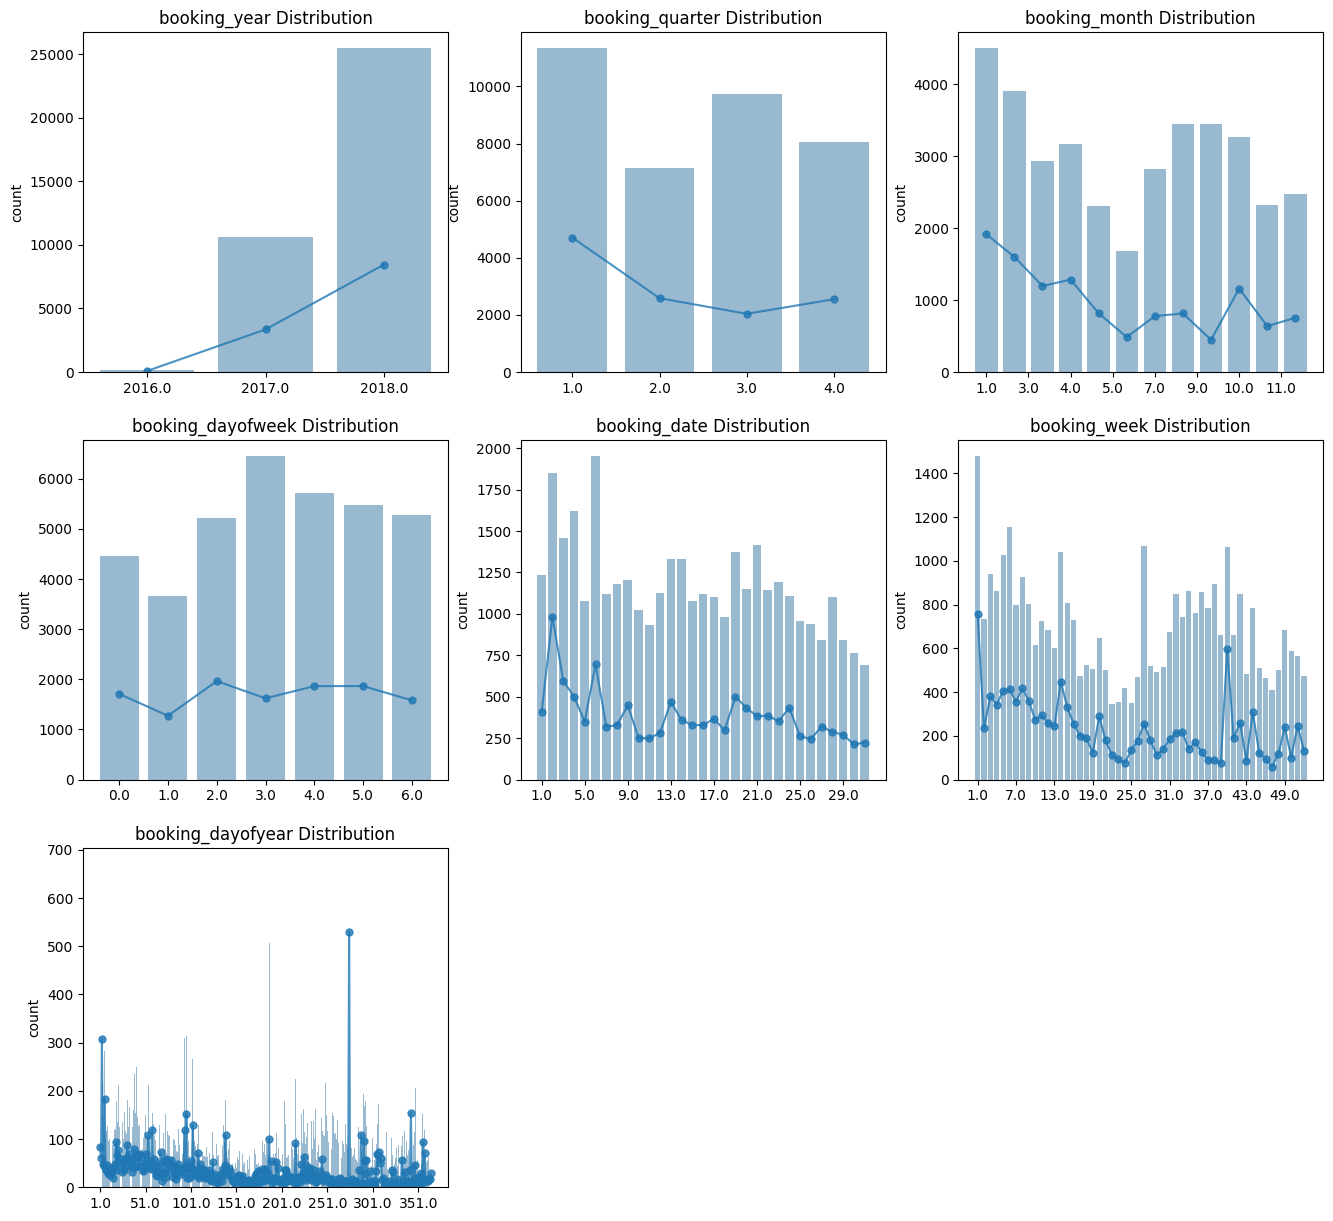

In [86]:
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*5))
ax = ax.flatten()

for i, column in enumerate(booking_columns):
    column = booking_columns[i]
    plot_axes = [ax[i]]
    sns.countplot(data=df, x=column, ax=ax[i], alpha=0.5)
    plot_dots_ordinal(column, ax[i])
    
    # titles
    ax[i].set_title(f'{column} Distribution')
    ax[i].set_xlabel(None)
    
    # axis
    if len(ax[i].get_xticklabels()) > 10:
        ax[i].xaxis.set_major_locator(MaxNLocator(10))
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')

In [96]:
arrival_columns = ['arrival_year', 'arrival_quarter', 'arrival_month', 'arrival_dayofweek', 
           'arrival_date', 'arrival_week', 'arrival_dayofyear']
n_cols = 3
n_rows = math.ceil(len(arrival_columns)/n_cols)

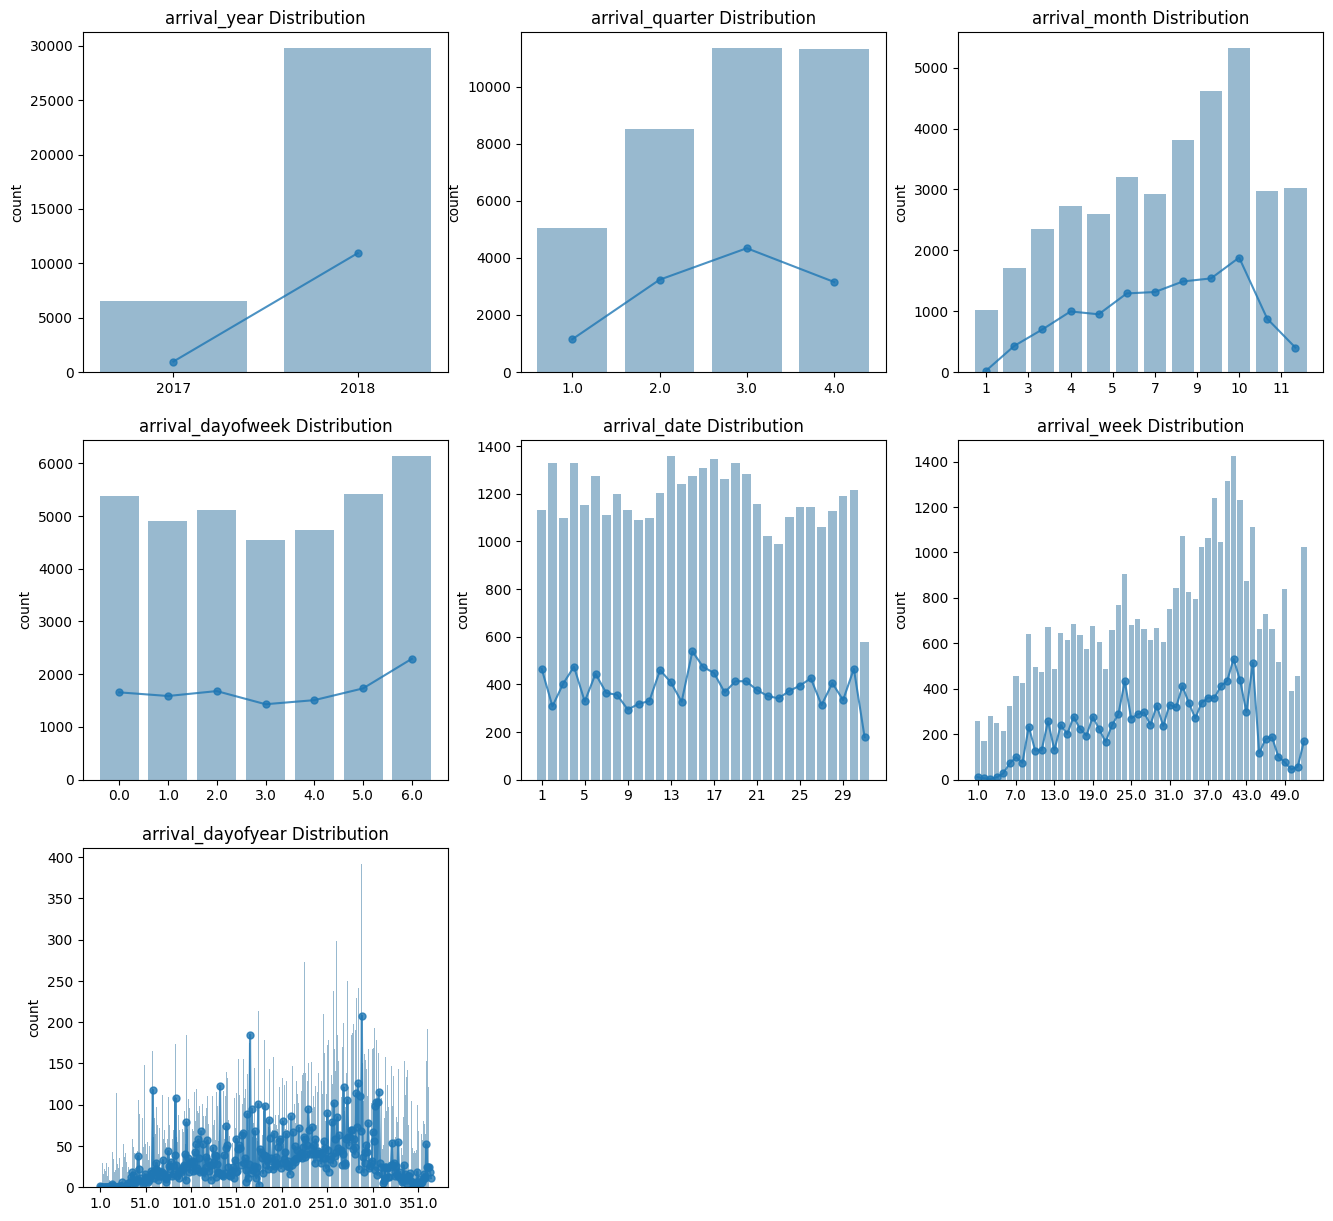

In [88]:
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*5))
ax = ax.flatten()

for i, column in enumerate(arrival_columns):
    column = arrival_columns[i]
    plot_axes = [ax[i]]
    sns.countplot(data=df, x=column, ax=ax[i], alpha=0.5)
    plot_dots_ordinal(column, ax[i])
    
    # titles
    ax[i].set_title(f'{column} Distribution')
    ax[i].set_xlabel(None)
    
    # axis
    if len(ax[i].get_xticklabels()) > 10:
        ax[i].xaxis.set_major_locator(MaxNLocator(10))
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
    

### Correlation Examination

In [89]:
for col in encoded_cat_cols:
    contingency_table = pd.crosstab(train[col], train['booking_status'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-Square Statistic against {col}: {chi2}, p-value: {p}")

Chi-Square Statistic against type_of_meal_plan_meal plan 1: 125.20030516392933, p-value: 4.6008112748307084e-29
Chi-Square Statistic against type_of_meal_plan_meal plan 2: 164.82097166098146, p-value: 1.0009639863487024e-37
Chi-Square Statistic against type_of_meal_plan_meal plan 3: 0.08672825087650701, p-value: 0.7683784566009777
Chi-Square Statistic against type_of_meal_plan_not selected: 4.713637852858255, p-value: 0.029924264251671034
Chi-Square Statistic against required_car_parking_space_0: 182.6619507454417, p-value: 1.2712515438944373e-41
Chi-Square Statistic against required_car_parking_space_1: 182.6619507454417, p-value: 1.2712515438944373e-41
Chi-Square Statistic against room_type_reserved_room_type 1: 7.165669293462316, p-value: 0.007431195904886962
Chi-Square Statistic against room_type_reserved_room_type 2: 0.4795754719574172, p-value: 0.4886146733188774
Chi-Square Statistic against room_type_reserved_room_type 3: 0.0, p-value: 1.0
Chi-Square Statistic against room_type_

Columns need to be removed: 'type_of_meal_plan_meal plan 3', 'type_of_meal_plan_not selected', 'required_car_parking_space_0', 'room_type_reserved_room_type 1', 'room_type_reserved_room_type 2', 'room_type_reserved_room_type 3', 'room_type_reserved_room_type 4', 'room_type_reserved_room_type 5', 'room_type_reserved_room_type 7', 'repeated_guest_0', 'market_segment_type_aviation'

In [90]:
for col in encoded_num_cols:
    contingency_table = pd.crosstab(train[col], train['booking_status'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-Square Statistic against {col}: {chi2}, p-value: {p}")

Chi-Square Statistic against no_of_adults_cat_0: 0.005770320214305398, p-value: 0.9394488341346938
Chi-Square Statistic against no_of_adults_cat_1: 319.8633136946578, p-value: 1.5512239330327838e-71
Chi-Square Statistic against no_of_adults_cat_2: 191.7381873413471, p-value: 1.3271840315801064e-43
Chi-Square Statistic against no_of_adults_cat_3: 19.509971519825797, p-value: 1.0007590694704993e-05
Chi-Square Statistic against no_of_adults_cat_greater than 3: 0.0, p-value: 1.0
Chi-Square Statistic against no_of_children_cat_0: 14.532368361299262, p-value: 0.00013777194763229058
Chi-Square Statistic against no_of_children_cat_1: 0.01075754520889233, p-value: 0.9173926762235817
Chi-Square Statistic against no_of_children_cat_2: 34.891619364617995, p-value: 3.485780409285669e-09
Chi-Square Statistic against no_of_children_cat_greater than 2: 0.1271703665066893, p-value: 0.7213841319687032
Chi-Square Statistic against no_of_weekend_nights_cat_0: 62.061661545874806, p-value: 3.328692947931645

In [103]:
for col in booking_columns:
    contingency_table = pd.crosstab(train[col], train['booking_status'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-Square Statistic against {col}: {chi2}, p-value: {p}")

Chi-Square Statistic against booking_year: 208.01539020430948, p-value: 6.761327020324649e-46
Chi-Square Statistic against booking_quarter: 917.5007165675287, p-value: 1.415685120456358e-198
Chi-Square Statistic against booking_month: 1134.3433297360082, p-value: 2.2739849491663586e-236
Chi-Square Statistic against booking_dayofweek: 404.9562092863519, p-value: 2.403766664292038e-84
Chi-Square Statistic against booking_date: 795.4723966260698, p-value: 5.4301072346663746e-148
Chi-Square Statistic against booking_week: 2008.9640661574485, p-value: 0.0
Chi-Square Statistic against booking_dayofyear: 4529.462413432297, p-value: 0.0


In [102]:
for col in arrival_columns:
    contingency_table = pd.crosstab(train[col], train['booking_status'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-Square Statistic against {col}: {chi2}, p-value: {p}")

Chi-Square Statistic against arrival_year: 1706.7633890332922, p-value: 0.0
Chi-Square Statistic against arrival_quarter: 598.5763763478282, p-value: 2.051232841933549e-129
Chi-Square Statistic against arrival_month: 1230.096487098625, p-value: 5.276673812121295e-257
Chi-Square Statistic against arrival_dayofweek: 120.36978929465931, p-value: 1.362720511287939e-23
Chi-Square Statistic against arrival_date: 316.7719939851462, p-value: 1.2863720066896948e-49
Chi-Square Statistic against arrival_week: 1670.9946370704013, p-value: 0.0
Chi-Square Statistic against arrival_dayofyear: 4046.399379201732, p-value: 0.0


In [93]:
correlation_results = {}
for col in scaled_num_cols:
    correlation, p_value = pointbiserialr(train[col], train['booking_status'])
    correlation_results[col] = {'correlation': correlation, 'p_value': p_value}
for key, value in correlation_results.items():
    print(f"{key}: Correlation={value['correlation']}, P-value={value['p_value']}")

no_of_adults_scaled: Correlation=0.09704176754465735, P-value=1.0904113383102812e-59
no_of_children_scaled: Correlation=0.02875724761279224, P-value=1.449213334654575e-06
no_of_weekend_nights_scaled: Correlation=0.0542131847424956, P-value=1.0095397005708502e-19
no_of_week_nights_scaled: Correlation=0.09270418852700613, P-value=1.3114865892638553e-54
no_of_previous_cancellations_scaled: Correlation=-0.03336786750904008, P-value=2.2576778915239028e-08
no_of_previous_bookings_not_canceled_scaled: Correlation=-0.06668400785159612, P-value=4.9577813463588394e-29
no_of_special_requests_scaled: Correlation=-0.23868930976689842, P-value=0.0
lead_time_scaled: Correlation=0.45211570236696524, P-value=0.0
avg_price_per_room_scaled: Correlation=0.1815680127260531, P-value=1.4458443915811147e-206


In [158]:
X_train = train.drop(['booking_status', 'Booking_ID'], axis = 1)
Y_train = train['booking_status']
X_test = test.drop(['booking_status', 'Booking_ID'], axis = 1)
Y_test = test['booking_status']

#### Model that bins Numberical Variables

In [153]:
dates_cols = ['booking_isweekend', 'arrival_isweekend']

In [159]:
from sklearn.linear_model import LogisticRegression

logRegModel = LogisticRegression(max_iter=10000).fit(X_train[list(encoded_cat_cols)+list(encoded_num_cols)+dates_cols], Y_train)

# Predict on the training and test data
Y_train_pred = logRegModel.predict(X_train[list(encoded_cat_cols)+list(encoded_num_cols)+dates_cols])
Y_test_pred = logRegModel.predict(X_test[list(encoded_cat_cols)+list(encoded_num_cols)+dates_cols])

In [160]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Calculate general metrics for the train set
print("**Training Set Metrics**")
print("Accuracy \t:", accuracy_score(Y_train, Y_train_pred))
print("Precision \t:", precision_score(Y_train, Y_train_pred))
print("Recall \t\t:", recall_score(Y_train, Y_train_pred))
print("F1 Score \t:", f1_score(Y_train, Y_train_pred))

print() # New Line

# Calculate general metrics for the test set
print("**Test Set Metrics**")
print("Accuracy \t:", accuracy_score(Y_test, Y_test_pred))
print("Precision \t:", precision_score(Y_test, Y_test_pred))
print("Recall \t\t:", recall_score(Y_test, Y_test_pred))
print("F1 Score \t:", f1_score(Y_test, Y_test_pred))

**Training Set Metrics**
Accuracy 	: 0.8061079039270187
Precision 	: 0.7503949447077409
Recall 		: 0.6988034523342487
F1 Score 	: 0.7236808694327358

**Test Set Metrics**
Accuracy 	: 0.8090753424657534
Precision 	: 0.5555555555555556
Recall 		: 0.35969084423305586
F1 Score 	: 0.4366654637315049


#### Model that scales Numberical Variables

In [ ]:
logRegModel = LogisticRegression(max_iter=10000).fit(X_train[list(encoded_cat_cols)+list(scaled_num_cols)+dates_cols], Y_train)

# Predict on the training and test data
Y_train_pred = logRegModel.predict(X_train[list(encoded_cat_cols)+list(scaled_num_cols)+dates_cols])
Y_test_pred = logRegModel.predict(X_test[list(encoded_cat_cols)+list(scaled_num_cols)+dates_cols])

In [162]:
# Calculate general metrics for the train set
print("**Training Set Metrics**")
print("Accuracy \t:", accuracy_score(Y_train, Y_train_pred))
print("Precision \t:", precision_score(Y_train, Y_train_pred))
print("Recall \t\t:", recall_score(Y_train, Y_train_pred))
print("F1 Score \t:", f1_score(Y_train, Y_train_pred))

print() # New Line

# Calculate general metrics for the test set
print("**Test Set Metrics**")
print("Accuracy \t:", accuracy_score(Y_test, Y_test_pred))
print("Precision \t:", precision_score(Y_test, Y_test_pred))
print("Recall \t\t:", recall_score(Y_test, Y_test_pred))
print("F1 Score \t:", f1_score(Y_test, Y_test_pred))

**Training Set Metrics**
Accuracy 	: 0.8018672938493336
Precision 	: 0.7556241729157477
Recall 		: 0.6720282463711259
F1 Score 	: 0.7113787375415282

**Test Set Metrics**
Accuracy 	: 0.8175146771037182
Precision 	: 0.5899621212121212
Recall 		: 0.3703923900118906
F1 Score 	: 0.4550766983199416


#### Model with simple feature selection

In [132]:
to_removed = ['type_of_meal_plan_meal plan 3', 'type_of_meal_plan_not selected', 'required_car_parking_space_0', 'room_type_reserved_room_type 1', 
              'room_type_reserved_room_type 2', 'room_type_reserved_room_type 3', 'room_type_reserved_room_type 4', 'room_type_reserved_room_type 5', 
              'room_type_reserved_room_type 7', 'repeated_guest_0', 'market_segment_type_aviation']

In [165]:
logRegModel = LogisticRegression(max_iter=10000).fit(X_train[[x for x in list(encoded_cat_cols)+list(scaled_num_cols)+dates_cols if x not in to_removed]], Y_train)

# Predict on the training and test data
Y_train_pred = logRegModel.predict(X_train[[x for x in list(encoded_cat_cols)+list(scaled_num_cols)+dates_cols if x not in to_removed]])
Y_test_pred = logRegModel.predict(X_test[[x for x in list(encoded_cat_cols)+list(scaled_num_cols)+dates_cols if x not in to_removed]])

In [166]:
# Calculate general metrics for the train set
print("**Training Set Metrics**")
print("Accuracy \t:", accuracy_score(Y_train, Y_train_pred))
print("Precision \t:", precision_score(Y_train, Y_train_pred))
print("Recall \t\t:", recall_score(Y_train, Y_train_pred))
print("F1 Score \t:", f1_score(Y_train, Y_train_pred))

print() # New Line

# Calculate general metrics for the test set
print("**Test Set Metrics**")
print("Accuracy \t:", accuracy_score(Y_test, Y_test_pred))
print("Precision \t:", precision_score(Y_test, Y_test_pred))
print("Recall \t\t:", recall_score(Y_test, Y_test_pred))
print("F1 Score \t:", f1_score(Y_test, Y_test_pred))

**Training Set Metrics**
Accuracy 	: 0.7995153588482645
Precision 	: 0.7538888888888889
Recall 		: 0.665457041977246
F1 Score 	: 0.706918107939154

**Test Set Metrics**
Accuracy 	: 0.8151908023483366
Precision 	: 0.5808893093661306
Recall 		: 0.36504161712247324
F1 Score 	: 0.44833880978459295
